# Glioma Grading Clinical and Mutation Features

In [1]:
from pathlib import Path

import matplotlib.font_manager
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from src.data_processing import normalize_dataset, process_data
from src.feature_estimators import (concat_important_features,
                                    get_feature_estimator,
                                    select_by_correlation_value)
from src.models import grid_search, voting_search
from src.utils import convert_result, get_csv_name, new_experiments_folder
from src.visualize import make_2d_representation

# Data processing
---

In [2]:
DATASETS_PATH = Path('datasets')
train_dataset_path = DATASETS_PATH / 'train.csv'
test_dataset_path = DATASETS_PATH / 'test.csv'

In [3]:
train_dataset = pd.read_csv(train_dataset_path, index_col=0)
test_dataset = pd.read_csv(test_dataset_path, index_col=0)

train_dataset.head()

,Grade,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,GBM,TCGA-06-A6S0,Male,79 years 183 days,Glioblastoma,black or african american,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-HT-8106,Male,53 years 197 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
2,LGG,TCGA-HT-7607,Female,61 years 305 days,"Astrocytoma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-QH-A6X5,Female,58 years 55 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
4,LGG,TCGA-P5-A5F1,Male,30 years 113 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


### Column Analysis

* The `Grade` column is our target.

* The column `Primary_Diagnosis` has 5 unique values, we will encode it with `Encoder`.

* Column `Case_ID` represents unique id of case, we will remove from our dataset.

* The following columns represent the gen mutations.
    ```text
    IDH1, TP53, ATRX, PTEN, EGFR, CIC, MUC16, PIK3CA,
    NF1, PIK3R1, FUBP1, RB1, NOTCH1, BCOR, CSMD3, SMARCA4,
    GRIN2A, IDH2, FAT4, PDGFRA
    ```
    They might be only `MUTATED` or `NOT_MUTATED`, so we will encode it with `Encoder`.

* The binary type column `Gender` will be encoded with `Encoder` too.

* The `Age_at_diagnosis` column has a string representation of date. We will convert it into the numeric type.

### Missing Data

We detect that 4 cases has no `Age_at_diagnosis` data. We decided to replace it.

## Feature selection
---

To investigate the most valuable features we will calculate correlation metrics.
For correlation analysis we used both encoders `OneHot` and `Label`, but results are the similar, so we kept only `Label` data for feature selection.
Different encoders will be used in training process.

In [4]:
encoder = 'Label'

data_for_feature_analysis = train_dataset.copy()
data_for_feature_analysis = process_data(data_for_feature_analysis, encoder=encoder,
                                         target='Grade', fill_na='mean')

> Note: Our experiments shows that `mean` strategy (`zero`, `mean`, `median` were tested) of filling missing data performs better score

In [5]:
data_for_feature_analysis


,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,2,79.501370,3,3,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,2,53.539726,2,5,0,0,1,1,1,...,1,1,1,1,1,1,1,1,0,1
2,1,1,61.835616,1,5,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,58.150685,4,5,0,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
4,1,2,30.309589,1,5,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0,2,51.297697,3,5,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
599,1,1,27.846575,2,5,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
600,1,2,29.087671,4,5,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
601,1,2,51.854795,6,5,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


2d Representation of our data is presented at the figure below

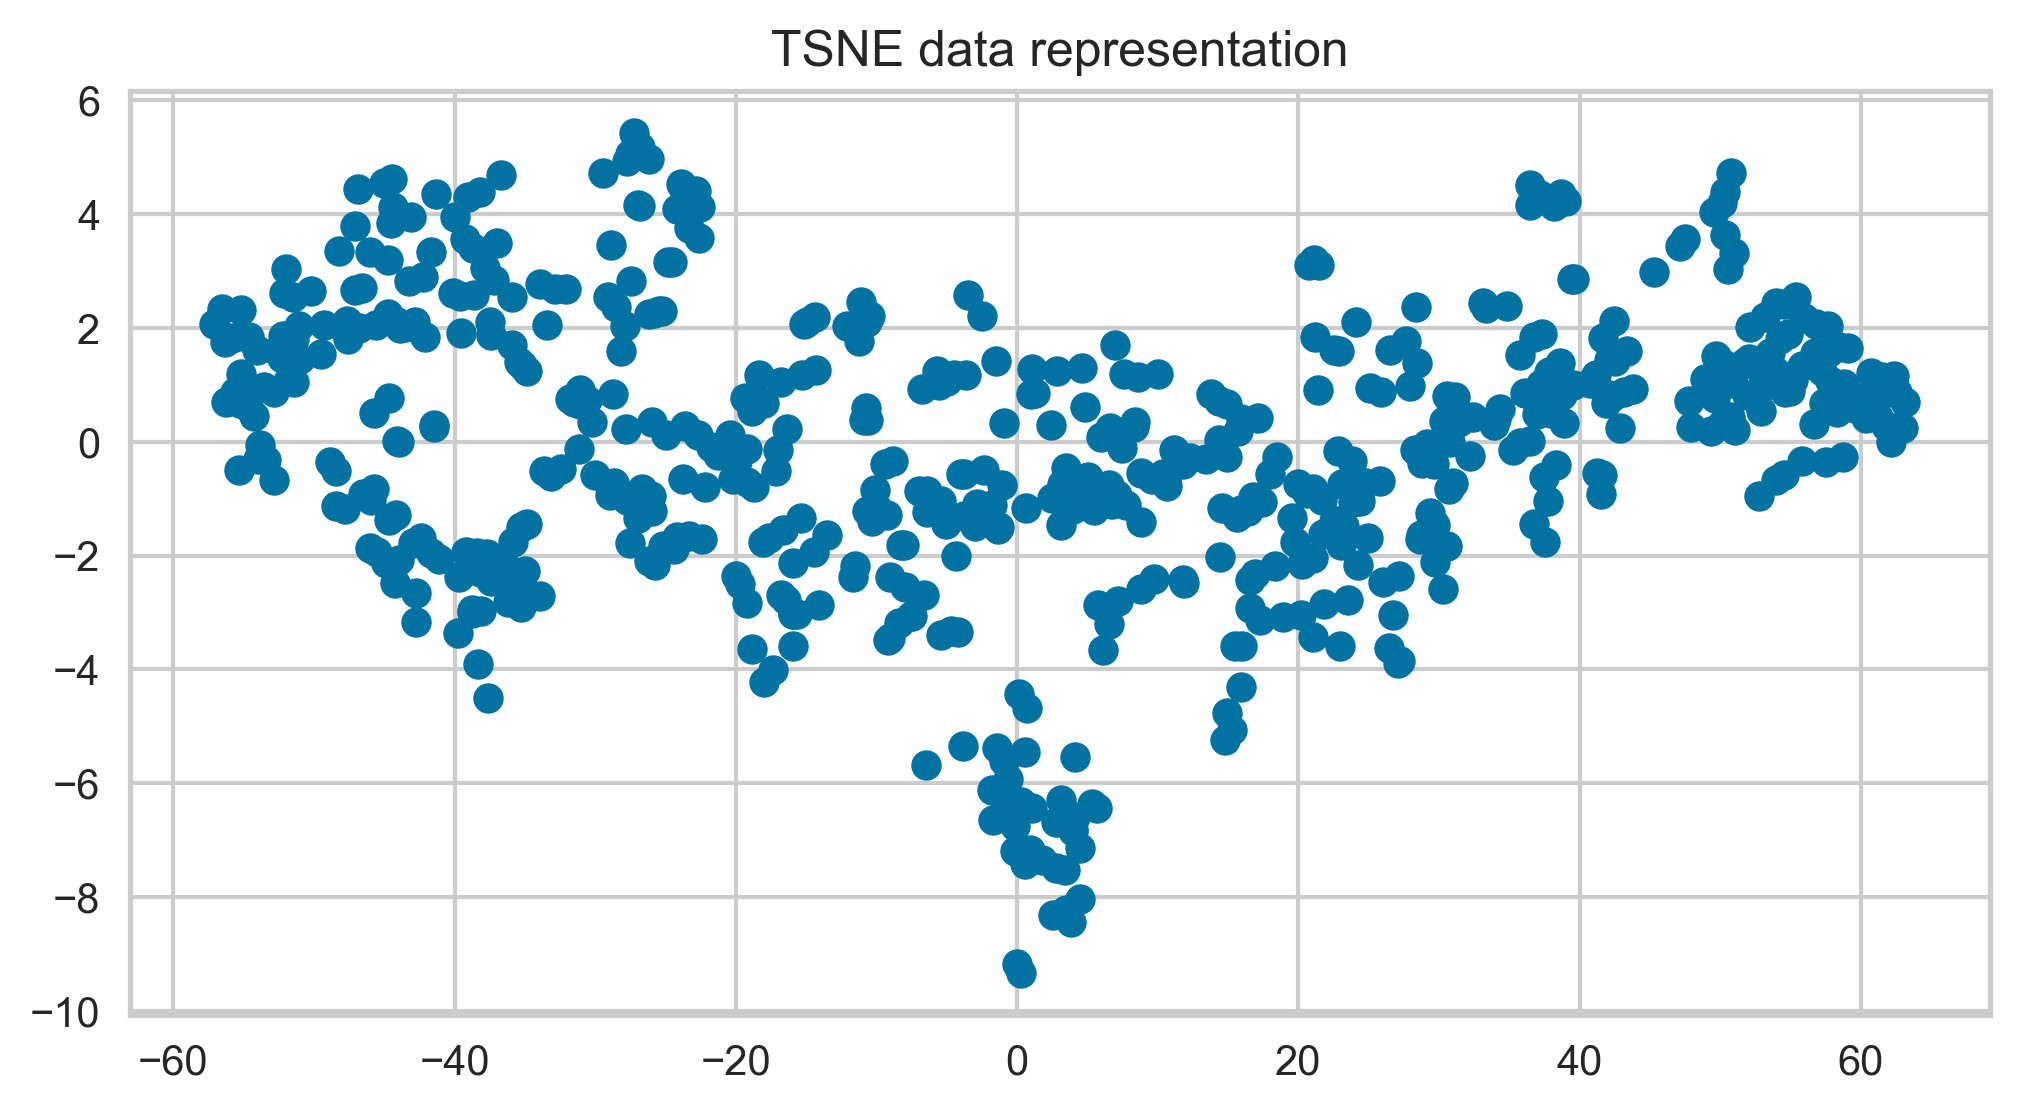

In [6]:
figure = make_2d_representation(data_for_feature_analysis)

In [7]:
targets = data_for_feature_analysis['Grade']
data_for_feature_analysis = normalize_dataset(data_for_feature_analysis.drop(columns=['Grade']))

### Mutual information
Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.


{'Primary_Diagnosis': 0.6749414476523922, 'IDH1': 0.301427248942439}

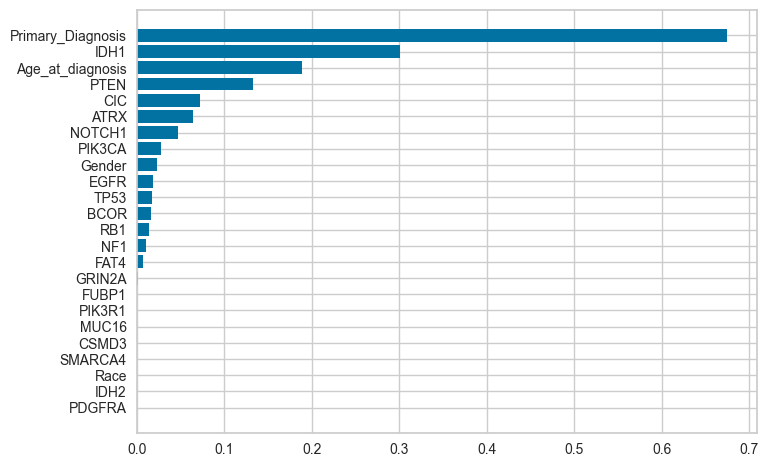

In [8]:
correlation_estimator = get_feature_estimator(data_for_feature_analysis, targets, method='mutual_info-classification')
mutual_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
mutual_important_values

The most valuable features are:
```text
Primary_Diagnosis, IDH1, Age_at_diagnosis
```

The least valuable features are:
```text
Gender, BCOR, FAT4, PIK3CA, Race, GRIN2A, PIK3R1
```

### Pearson's 

The Pearson correlation measures the strength of the linear relationship between two variables.

{'PTEN': 0.3855572212271784,
 'Primary_Diagnosis': 0.23889448371236618,
 'EGFR': 0.23071818366672245,
 'RB1': 0.22130467653793692,
 'CIC': -0.30395162606609344,
 'ATRX': -0.33855245211139745,
 'Age_at_diagnosis': -0.5268886179382668,
 'IDH1': -0.7174747581508003}

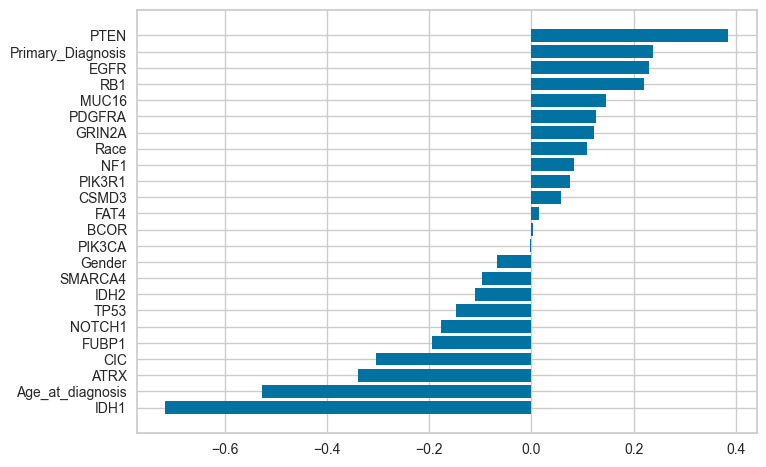

In [9]:
correlation_estimator = get_feature_estimator(data_for_feature_analysis, targets, method='pearson')
pearson_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
pearson_important_values

The most valuable features are
```text
IDH1, Age_at_diagnosis, PTEN, ATRX, CIC
```

The least valuable features are:
```text
BKOR, PIK3CA, FAT4
```

### Selected Features

We decided to automatically select features if their correlation metric is greater than 0.2

In [10]:
keep_columns = concat_important_features(pearson_important_values, mutual_important_values)
training_data = data_for_feature_analysis[keep_columns]
keep_columns

['EGFR',
 'CIC',
 'Primary_Diagnosis',
 'Age_at_diagnosis',
 'ATRX',
 'RB1',
 'IDH1',
 'PTEN']

## Experiments with model

In [11]:
validation_data = test_dataset.copy()
validation_data = process_data(validation_data, encoder=encoder)
validation_data = normalize_dataset(validation_data)
validation_data = validation_data[keep_columns]

x_train, x_test, y_train, y_test = train_test_split(training_data, targets, test_size=0.3, random_state=42)

model_names = ('RandomForest', 'CatBoost', 'LogisticRegression')

results_path = Path('results')
new_experiments_folder(results_path)

for model_name in model_names:
    classifier = grid_search(model_name, x_train, y_train)
    prediction = classifier.predict(x_test)

    score = f1_score(y_test, prediction)
    print(f'Model {model_name}: {score: .4f}')

    val_prediction = classifier.predict(validation_data)
    result = convert_result(val_prediction, inverse=True)
    result_name = get_csv_name(results_path, model_name, score)
    result.to_csv(result_name, index=False)

Model RandomForest:  0.9869


In [ ]:
ensemble_model = voting_search(x_train, y_train)

prediction = classifier.predict(x_test)
score = f1_score(y_test, prediction)
print(f'Model Voting Search: {score: .4f}')

Model Voting Search:  0.8807
